In [1]:
import tensorly as tl
from tensorly.decomposition import parafac,tucker

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,15)

import json
import dill

In [2]:
mumbai = '../data/mumbai-hexclusters-2019-4-All-HourlyAggregate.csv'
bengaluru = '../data/bangalore-wards-2019-4-All-HourlyAggregate.csv'
delhi = '../data/new_delhi-wards-2018-4-All-HourlyAggregate.csv'
kolkata = '../data/kolkata-wards-2019-4-All-HourlyAggregate.csv'
hyderabad = '../data/hyderabad-wards-2019-4-All-HourlyAggregate.csv'

In [3]:
def explained(tensor, factors, mask, algo):
    if algo=='cp':
        error_tensor = tensor - tl.cp_to_tensor(factors)
    elif algo=='tucker':
        error_tensor = tensor - tl.tucker_to_tensor(factors)
        
    error = tl.norm(error_tensor * mask)
    
    total_variance = tl.norm(tensor*mask)**2
    explained_variance = total_variance - error**2
    explained_variance_normalized = explained_variance/total_variance
    
    return explained_variance_normalized

In [4]:
def fillTensor(x,nptensor):
    nptensor[x.dstid-1 ,x.sourceid-1, x.hod] = x.mean_travel_time
    return 0

In [5]:
def decompose(cityfile, upto_rank=5):
    df = pd.read_csv(cityfile)
    df_nodes = max(df.sourceid.max(), df.dstid.max())
    print('df max nodes ->', df_nodes)

    dfMean = df.groupby('hod').mean()

    dfTensor = np.zeros( (df_nodes, df_nodes, 24))
    df.pipe(lambda x: fillTensor(x, dfTensor))

    print(dfTensor[100,100,23])
    print(df[ df.sourceid == 101][df.dstid ==101].mean_travel_time)

    print( (df.mean_travel_time == 0).any())
    df_mask = (dfTensor!=0)*1

    df_cp = []
    for k in range(1,upto_rank):
        df_factors , df_errors = parafac(dfTensor, rank=k, return_errors = 1, orthogonalise=True, mask=df_mask)
        df_cp.append(df_factors)
        print(k,end='\t')


    df_tucker=[]
    for k in range(1,upto_rank):
        df_factors  = tucker(dfTensor, rank=k,  mask=df_mask)
        df_tucker.append(df_factors)
        print(k,end='\t')

    df_cp_explained = [explained(dfTensor, f, df_mask, algo='cp') for f in df_cp ]
    df_tucker_explained = [explained(dfTensor, f, df_mask, algo='tucker') for f in df_tucker ]
    
    return df_cp_explained,df_tucker_explained, df_cp, df_tucker

In [6]:
bengaluru_decomp = decompose(bengaluru, 4)

df max nodes -> 198
326.11
176741    326.11
Name: mean_travel_time, dtype: float64
False


/home/sampad/pyv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


1	2	3	

/home/sampad/pyv/lib/python3.6/site-packages/tensorly/tucker_tensor.py:357: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)
/home/sampad/pyv/lib/python3.6/site-packages/tensorly/decomposition/_tucker.py:71: Warning: Masking occurs after initialization. Therefore, random initialization is recommended.
  warnings.warn(message, Warning)


1	2	3	

In [7]:
def QXfile2tensor(QXfile):
    QXdf = pd.read_csv(QXfile)
    QXnodes = max(QXdf.sourceid.max(), QXdf.dstid.max())
    #print(QXnodes)
    QXtensor = np.zeros ( (QXnodes, QXnodes, 24) )
    QXdf.pipe(lambda x: fillTensor(x,QXtensor))
    #assert float(QXdf[QXdf.sourceid==100]QXdf.dstid==120][QXdf.hod==10].mean_travel_time) ==QXtensor[119,99,10]
    return QXtensor

def validate(QXtensor,cp_factors, tucker_factors):
    #print
    #print(float(QXdf[QXdf.sourceid==100][QXdf.dstid==120][QXdf.hod==10].mean_travel_time), QXtensor[119,99,10])
    
    QXrec_cp = tl.cp_to_tensor(cp_factors)
    QXrec_tucker = tl.tucker_to_tensor(tucker_factors)
    
    QXmask = (QXtensor!=0)*1
    
    cp_error = (QXrec_cp - QXtensor)*QXmask
    tucker_error = (QXrec_tucker - QXtensor)*QXmask
    
    cp_rel_error = tl.norm(cp_error) / tl.norm(QXtensor * QXmask)
    tucker_rel_error = tl.norm(tucker_error) / tl.norm(QXtensor * QXmask)
    
    return cp_rel_error, tucker_rel_error

In [8]:
bengaluru18Q4 = '../data/bangalore-wards-2018-4-All-HourlyAggregate.csv'
bengaluru19Q3 = '../data/bangalore-wards-2019-3-All-HourlyAggregate.csv'
bengaluru19Q2 = '../data/bangalore-wards-2019-2-All-HourlyAggregate.csv'
bengaluru19Q1 = '../data/bangalore-wards-2019-1-All-HourlyAggregate.csv'
bengaluru20Q1 = '../data/bangalore-wards-2020-1-All-HourlyAggregate.csv'

In [9]:
def rank2val(rank):
    cp_errors,tucker_errors = [],[]
    for x in [bengaluru18Q4,bengaluru19Q1, bengaluru19Q2, bengaluru19Q3, bengaluru, bengaluru20Q1]:
        QXtensor = QXfile2tensor(x)
        _cp,_tucker = validate(QXtensor, bengaluru_decomp[2][rank], bengaluru_decomp[3][rank])
        cp_errors.append(_cp)
        tucker_errors.append(_tucker)
        
    svd_errors = []
    

    return cp_errors, tucker_errors

In [10]:
bvals = [rank2val(r) for r in range(3)]

In [11]:
bvalsdf = pd.DataFrame({
                      'time': ['18Q4','19Q1','19Q2','19Q3','19Q4*', '20Q1'],
                      'cp1':bvals[0][0], 'tucker1':bvals[0][1],
                      'cp2':bvals[1][0], 'tucker2':bvals[1][1],
                      'cp3':bvals[2][0], 'tucker3':bvals[2][1],
                      
                     })


In [12]:
bvalsdf

,time,cp1,tucker1,cp2,tucker2,cp3,tucker3
0,18Q4,0.371034,0.371031,0.287977,0.287640,0.180648,0.179230
1,19Q1,0.371275,0.371272,0.286936,0.286661,0.179503,0.177556
2,19Q2,0.361082,0.361081,0.275788,0.275623,0.169148,0.167722
3,19Q3,0.365177,0.365176,0.275024,0.274836,0.171786,0.169782
4,19Q4*,0.362903,0.362904,0.275018,0.274653,0.166432,0.164595
5,20Q1,0.377419,0.377415,0.288386,0.288017,0.177060,0.175261


Text(0.5, 1.0, 'Validation for CP rank3 training on Bengaluru 2019Q4')

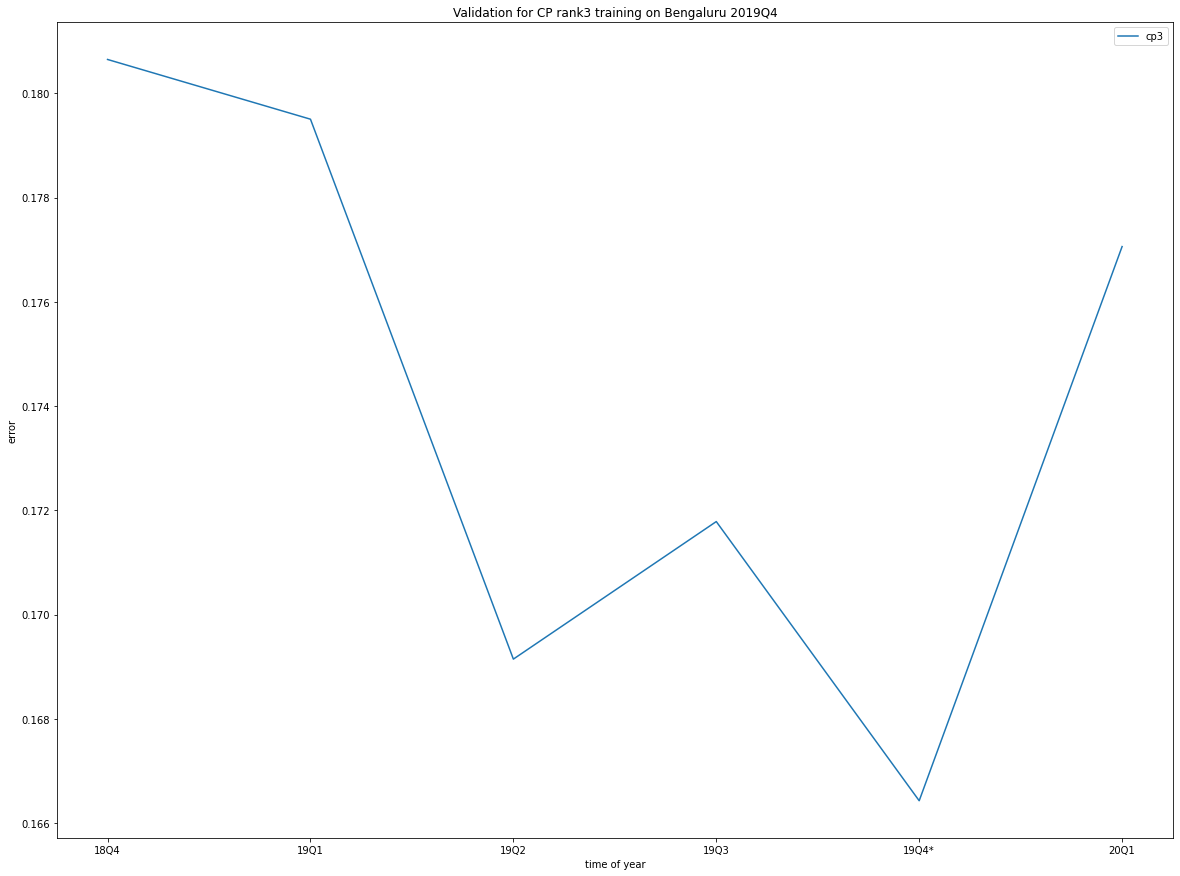

In [13]:
ax=bvalsdf.plot('time',['cp3'])
ax.set(xlabel='time of year', ylabel='error')
plt.title('Validation for CP rank3 training on Bengaluru 2019Q4')

Text(0.5, 1.0, 'Validation for Tucker rank3 training on Bengaluru 2019Q4')

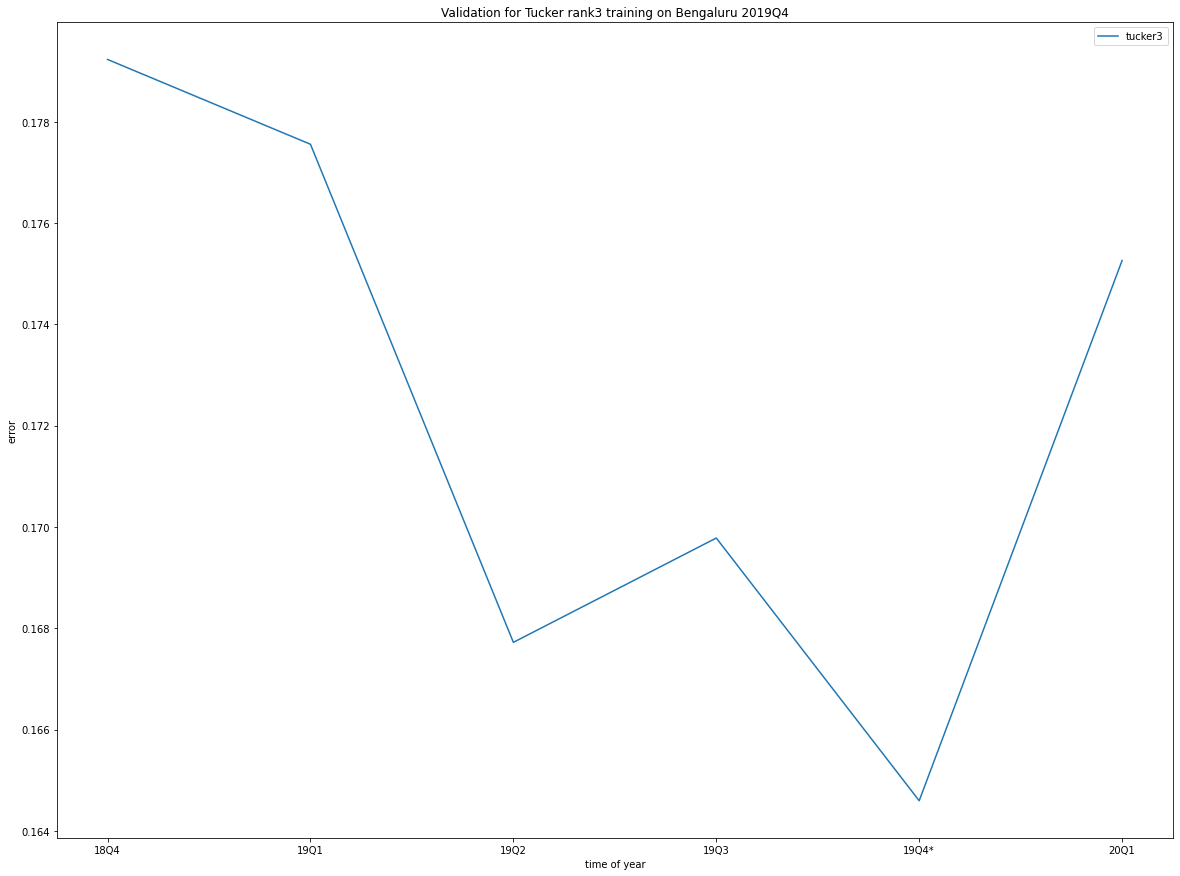

In [14]:
ax=bvalsdf.plot('time',['tucker3'])
ax.set(xlabel='time of year', ylabel='error')
plt.title('Validation for Tucker rank3 training on Bengaluru 2019Q4')

Text(0.5, 1.0, 'Validation for CP training on Bengaluru 2019Q4')

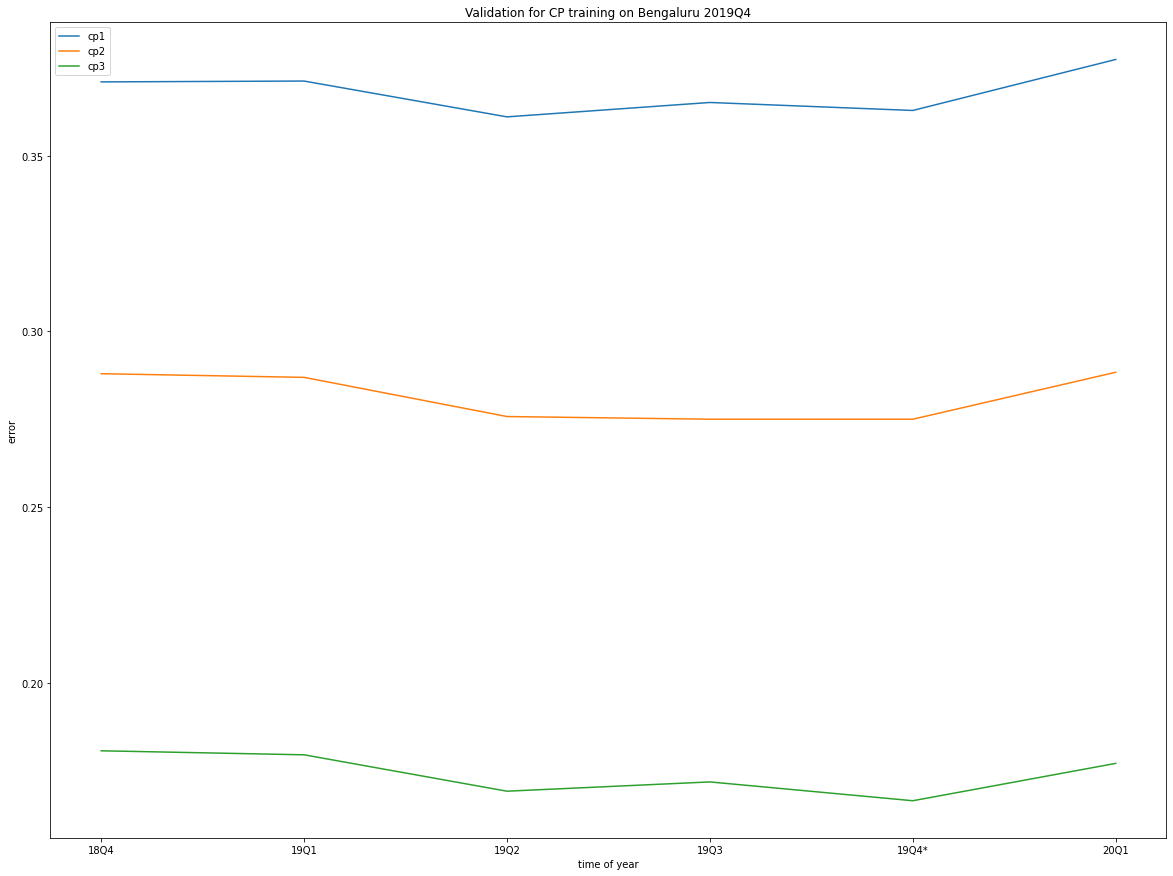

In [15]:
ax=bvalsdf.plot('time',['cp1','cp2','cp3'])
ax.set(xlabel='time of year', ylabel='error')
plt.title('Validation for CP training on Bengaluru 2019Q4')

Text(0.5, 1.0, 'Validation for Tucker training on bengaluru 2019Q4')

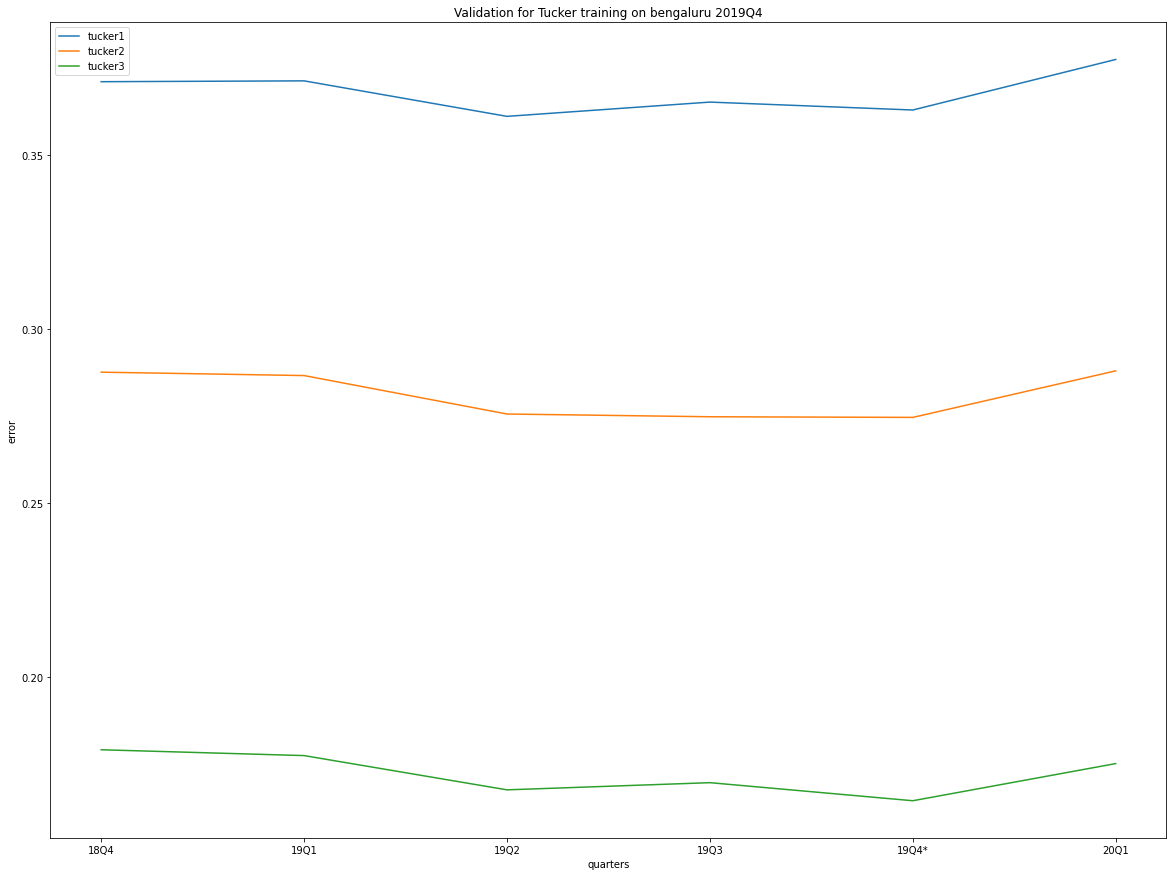

In [16]:
ax=bvalsdf.plot('time',['tucker1','tucker2','tucker3'])
ax.set(xlabel='quarters', ylabel='error')
plt.title('Validation for Tucker training on bengaluru 2019Q4')

In [17]:
# 19Q4 vs other quarters direct
def QXYcorr(QYfile):
    QYtensor = QXfile2tensor(QYfile)
    maskQY = (QYtensor!=0)*1
    errors=[]
    for x in [bengaluru18Q4,bengaluru19Q1, bengaluru19Q2, bengaluru19Q3, bengaluru, bengaluru20Q1]:
        QXtensor = QXfile2tensor(x)
        maskQX = (QXtensor!=0)*1
        mask = maskQX * maskQY
        
        err = (QXtensor - QYtensor)*mask
        rel_err = np.linalg.norm(err)/np.linalg.norm(QXtensor*mask)
        errors.append(rel_err)
        
    return errors
        


In [18]:
QXY_corr_error = QXYcorr(bengaluru)

<AxesSubplot:>

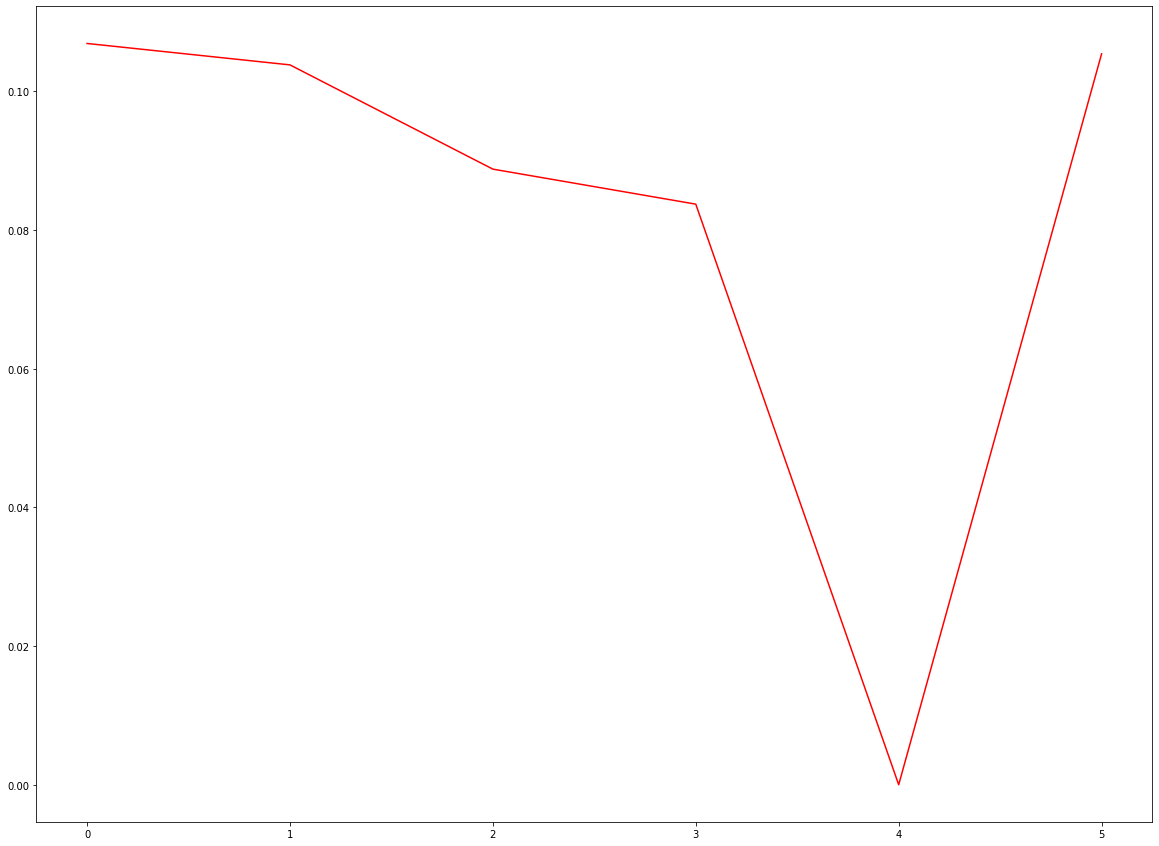

In [19]:
sns.lineplot(data=QXY_corr_error, color='red')